In [1]:
!pip install opencv-python
!pip install segmentation-models-pytorch
!pip install torch

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import urllib.request
import os
import numpy as np
import tarfile
import shutil
import glob
from torch.utils.data import Dataset, DataLoader
import cv2 as cv
import matplotlib.pyplot as plt
import torchvision.models as models
from tqdm import tqdm
# from google.colab import drive

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if torch.cuda.is_available():
  device=torch.device('cuda:0')
  print('Cuda')
else:
  device=torch.device('cpu')
  print('cpu')

Cuda


In [6]:
import os
import tarfile
import shutil
import urllib.request
from concurrent.futures import ThreadPoolExecutor
import time
import sys

url = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar'
path = 'VOC'

def get_archive(path, url):
    """Download the archive from the given URL and save it to the specified path."""
    try:
        os.makedirs(path, exist_ok=True)
        print(f"[INFO] Directory created or already exists: {path}")
    except Exception as e:
        print(f"[ERROR] Failed to create directory: {e}")
    filename = 'devkit.tar'
    file_path = os.path.join(path, filename)

    try:
        print(f"[INFO] Starting download from {url}...")
        def download_progress(count, block_size, total_size):
            percent = int(count * block_size * 100 / total_size)
            if percent % 10 == 0:  # Show progress every 10%
                sys.stdout.write(f"\r[INFO] Downloading: {percent}%")
                sys.stdout.flush()

        start_time = time.time()
        urllib.request.urlretrieve(url, file_path, reporthook=download_progress)
        elapsed_time = time.time() - start_time
        print(f"\n[INFO] Download completed in {elapsed_time:.2f} seconds: {file_path}")
    except Exception as e:
        print(f"[ERROR] Failed to download file: {e}")
        raise

    return file_path

def extract(file_path, output_dir='./'):
    """Extract the tar file to the specified output directory."""
    try:
        print(f"[INFO] Starting extraction of {file_path}...")
        start_time = time.time()
        with tarfile.open(file_path) as tar_file:
            total_members = len(tar_file.getmembers())
            for i, member in enumerate(tar_file.getmembers()):
                tar_file.extract(member, path=output_dir)
                if (i + 1) % max(1, total_members // 10) == 0:  # Show progress every 10%
                    percent = int((i + 1) / total_members * 100)
                    sys.stdout.write(f"\r[INFO] Extracting: {percent}%")
                    sys.stdout.flush()
        elapsed_time = time.time() - start_time
        print(f"\n[INFO] Extraction completed in {elapsed_time:.2f} seconds. Extracted to: {output_dir}")
    except Exception as e:
        print(f"[ERROR] Failed to extract file: {e}")
        raise

def cleanup(path):
    """Remove the specified temporary directory."""
    try:
        print(f"[INFO] Starting cleanup of temporary directory: {path}...")
        start_time = time.time()
        shutil.rmtree(path)
        elapsed_time = time.time() - start_time
        print(f"[INFO] Cleanup completed in {elapsed_time:.2f} seconds. Removed: {path}")
    except Exception as e:
        print(f"[ERROR] Failed to clean up directory: {e}")
        raise
try:
    print("[INFO] Starting the archive download and extraction process...")
    tar_path = get_archive(path, url)
    extract(tar_path, './')
    cleanup(path)
    print("[INFO] All tasks completed successfully.")
except Exception as e:
    print(f"[CRITICAL] Process failed: {e}")

[INFO] Starting the archive download and extraction process...
[INFO] Directory created or already exists: VOC
[INFO] Starting download from http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar...
[INFO] Downloading: 100%
[INFO] Download completed in 509.28 seconds: VOC/devkit.tar
[INFO] Starting extraction of VOC/devkit.tar...
[INFO] Extracting: 99%
[INFO] Extraction completed in 3.29 seconds. Extracted to: ./
[INFO] Starting cleanup of temporary directory: VOC...
[INFO] Cleanup completed in 0.12 seconds. Removed: VOC
[INFO] All tasks completed successfully.


In [7]:
VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

In [8]:
class VocDataset(Dataset):
    def __init__(self, dir, color_map):
        self.root = os.path.join(dir, 'VOCdevkit/VOC2012')
        self.target_dir = os.path.join(self.root, 'SegmentationClass')
        self.images_dir = os.path.join(self.root, 'JPEGImages')
        file_list = os.path.join(self.root, 'ImageSets/Segmentation/trainval.txt')
        self.files = [line.strip() for line in open(file_list)]
        self.color_map = color_map

    def convert_to_segmentation_mask(self, mask):
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(self.color_map)), dtype=np.float32)
        for label_index, label in enumerate(self.color_map):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image_id = self.files[index]
        image_path = os.path.join(self.images_dir, f"{image_id}.jpg")
        label_path = os.path.join(self.target_dir, f"{image_id}.png")
        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = cv.resize(image, (256, 256))
        image = image / 255.0
        image = torch.tensor(image).float()
        label = cv.imread(label_path)
        label = cv.cvtColor(label, cv.COLOR_BGR2RGB)
        label = cv.resize(label, (256, 256))
        label = self.convert_to_segmentation_mask(label)
        label = torch.tensor(label).float()
        return image, label

    def __len__(self):
        return len(self.files)

In [9]:
import random

def create_iid_partitions(dataset, num_clients):
    num_items_per_client = len(dataset) // num_clients
    all_indices = np.arange(len(dataset))
    np.random.shuffle(all_indices)
    return {i: all_indices[i * num_items_per_client:(i + 1) * num_items_per_client] for i in range(num_clients)}

def create_non_iid_partitions(dataset, num_clients, shards_per_client=2):
    num_shards = num_clients * shards_per_client
    shard_size = len(dataset) // num_shards
    all_indices = np.arange(len(dataset))
    data_by_label = np.argsort([torch.argmax(label.sum(dim=(0, 1))).item() for _, label in dataset])
    shards = [data_by_label[i * shard_size:(i + 1) * shard_size] for i in range(num_shards)]
    random.shuffle(shards)
    return {i: np.concatenate(shards[i * shards_per_client:(i + 1) * shards_per_client]) for i in range(num_clients)}

In [53]:
data = VocDataset('./', VOC_COLORMAP)

num_clients = 20

iid_partitions = create_iid_partitions(data, num_clients)
print("Client 0 IID Partition Indices:")
print(iid_partitions[0])

non_iid_partitions = create_non_iid_partitions(data, num_clients, shards_per_client=2)
print("\nClient 0 Non-IID Partition Indices:")
print(non_iid_partitions[0])

Client 0 IID Partition Indices:
[1391 1840 1522  818 1921 2054 2286 1847  693  727 2714  724 2028 2123
 1392  295 1273 2851 1121  138  725   28 2019 1990 2148 1137 1627 2546
 1501 2486 2813 1581 2424 1654   79 1556 2533 1639  651 1049  645 2627
 1313  658 1931  474 1805 2129 1053 2674 1024  162 2209 1400  357 2660
 1212   25 1092 1807  688  472 1483 2767 1948 2542  263 1537  171 1475
  801 1722 2281  183  394 2616 1326    5  451  869 1034 1792 1595  729
  904 1813 2452  752 2335 1056 2039 1462 2584  221 2432  575 1695  560
  477  126 1145 2272 1540  640 2160 1498  260    4  269 2803 2896 1107
 1433 2442 2153  247  515 1714 2601  194  799 2449 2742 1554 1602  803
 2421 1960 1920  324  831 1511  585  155 2765 2005  359 2222 2760 2638
  187 2749 2695 1216  792]

Client 0 Non-IID Partition Indices:
[2264 2266 2267 2268 2269 2270 2271 2272 2274 2299 2202 2200 2123 2124
 2125 2128 2129 2130 2136 2137 2138 2139 2140 2141 2143 2144 2145 2147
 2151 2122 2152 2121 2117 2100 2101 2102 2103 2104 2

In [10]:
def train_client_model(model, train_loader, criterion, optimizer, num_epochs=1):
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.int64)
            images = images.permute(0, 3, 1, 2)
            labels = labels.permute(0, 3, 1, 2)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

def evaluate_model(model, val_loader, criterion, metrics):
    model.eval()
    val_losses = []
    ious = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.int64)
            images = images.permute(0, 3, 1, 2)
            labels = labels.permute(0, 3, 1, 2)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            iou = metrics(outputs, labels)
            val_losses.append(val_loss.item())
            ious.append(iou.item())
    return np.mean(val_losses), np.mean(ious)

def average_weights(global_model, client_models):
    global_state_dict = global_model.state_dict()
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.stack([client_model.state_dict()[key].float() for client_model in client_models], 0).mean(0)
    global_model.load_state_dict(global_state_dict)
    return global_model

In [12]:
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, Subset
from segmentation_models_pytorch import utils

def federated_learning_with_analysis(global_model, train_data, val_data, num_clients=10, rounds=10,
                                      target_iou=0.8, batch_size=10, lr=0.0001, iid=True, full_participation=True):
    train_partitions = create_iid_partitions(train_data, num_clients) if iid else create_non_iid_partitions(train_data, num_clients)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    criterion = smp.utils.losses.DiceLoss(eps=1.)
    metrics = smp.utils.metrics.IoU(eps=1.)

    iou_history = []

    for round_num in range(rounds):
        print(f"\nRound {round_num + 1}/{rounds}")
        participating_clients = range(num_clients) if full_participation else np.random.choice(num_clients, num_clients // 2, replace=False)

        client_models = [smp.Unet(encoder_name='resnet18', classes=21, activation='softmax').to(device) for _ in participating_clients]
        for client_model in client_models:
            client_model.load_state_dict(global_model.state_dict())

        for client_id, client_model in zip(participating_clients, client_models):
            client_indices = train_partitions[client_id]
            train_loader = DataLoader(Subset(train_data, client_indices), batch_size=batch_size, shuffle=True)
            optimizer = torch.optim.Adam(client_model.parameters(), lr=lr)
            train_client_model(client_model, train_loader, criterion, optimizer)

        global_model = average_weights(global_model, client_models)
        val_loss, val_iou = evaluate_model(global_model, val_loader, criterion, metrics)
        iou_history.append(val_iou)

        print(f"Validation Loss: {val_loss:.4f}, Validation IoU: {val_iou:.4f}")

        if val_iou >= target_iou:
            print(f"Target IoU {target_iou} reached. Stopping training.")
            break

    return iou_history

# data = VocDataset('/content', VOC_COLORMAP)
data = VocDataset('./', VOC_COLORMAP)
train_set, val_set = torch.utils.data.random_split(data, [int(len(data) * 0.9), len(data) - int(len(data) * 0.9)])
global_model = smp.Unet(encoder_name='resnet18', classes=21, activation='softmax').to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/songcw/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:04<00:00, 11.6MB/s]


In [13]:
def plot_results(iou_history, title):
    plt.figure()
    for label, history in iou_history.items():
        plt.plot(history, label=label)
    plt.title(title)
    plt.xlabel('Round')
    plt.ylabel('IoU')
    plt.legend()
    plt.show()

## IID vs Non-IID comparison

In [14]:
print("\n=== IID Partition Analysis ===")
iou_history_iid = federated_learning_with_analysis(
    global_model, train_set, val_set, num_clients=10, rounds=30, target_iou=0.8, iid=True
)


=== IID Partition Analysis ===

Round 1/30


/home/songcw/anaconda3/envs/fed_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Validation Loss: 0.9191, Validation IoU: 0.0308

Round 2/30
Validation Loss: 0.8699, Validation IoU: 0.0459

Round 3/30
Validation Loss: 0.8062, Validation IoU: 0.0477

Round 4/30
Validation Loss: 0.7569, Validation IoU: 0.2207

Round 5/30
Validation Loss: 0.7214, Validation IoU: 0.3422

Round 6/30
Validation Loss: 0.6444, Validation IoU: 0.4070

Round 7/30
Validation Loss: 0.5858, Validation IoU: 0.4850

Round 8/30
Validation Loss: 0.5416, Validation IoU: 0.5192

Round 9/30
Validation Loss: 0.5040, Validation IoU: 0.5524

Round 10/30
Validation Loss: 0.4592, Validation IoU: 0.5948

Round 11/30
Validation Loss: 0.4256, Validation IoU: 0.6185

Round 12/30
Validation Loss: 0.4083, Validation IoU: 0.6254

Round 13/30
Validation Loss: 0.3713, Validation IoU: 0.6481

Round 14/30
Validation Loss: 0.3497, Validation IoU: 0.6630

Round 15/30
Validation Loss: 0.3307, Validation IoU: 0.6737

Round 16/30
Validation Loss: 0.3165, Validation IoU: 0.6779

Round 17/30
Validation Loss: 0.2961, Validat

In [23]:
# data = VocDataset('/content', VOC_COLORMAP)
data = VocDataset('./', VOC_COLORMAP)
train_set, val_set = torch.utils.data.random_split(data, [int(len(data) * 0.9), len(data) - int(len(data) * 0.9)])
global_model = smp.Unet(encoder_name='resnet18', classes=21, activation='softmax').to(device)

print("\n=== Non-IID Partition Analysis ===")
iou_history_non_iid = federated_learning_with_analysis(
    global_model, train_set, val_set, num_clients=10, rounds=30, target_iou=0.8, iid=False
)


=== Non-IID Partition Analysis ===

Round 1/30
Validation Loss: 0.8986, Validation IoU: 0.0131

Round 2/30
Validation Loss: 0.7882, Validation IoU: 0.2078

Round 3/30
Validation Loss: 0.7517, Validation IoU: 0.2918

Round 4/30
Validation Loss: 0.7183, Validation IoU: 0.3463

Round 5/30
Validation Loss: 0.6846, Validation IoU: 0.3820

Round 6/30
Validation Loss: 0.6412, Validation IoU: 0.4255

Round 7/30
Validation Loss: 0.6001, Validation IoU: 0.4761

Round 8/30
Validation Loss: 0.5608, Validation IoU: 0.5005

Round 9/30
Validation Loss: 0.5399, Validation IoU: 0.5212

Round 10/30
Validation Loss: 0.4788, Validation IoU: 0.5792

Round 11/30
Validation Loss: 0.4424, Validation IoU: 0.6055

Round 12/30
Validation Loss: 0.4187, Validation IoU: 0.6195

Round 13/30
Validation Loss: 0.3971, Validation IoU: 0.6309

Round 14/30
Validation Loss: 0.3692, Validation IoU: 0.6559

Round 15/30
Validation Loss: 0.3523, Validation IoU: 0.6605

Round 16/30
Validation Loss: 0.3177, Validation IoU: 0.68

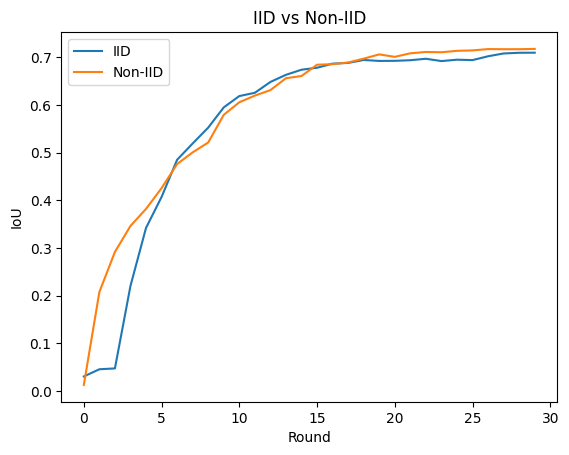

In [24]:
plot_results({'IID': iou_history_iid, 'Non-IID': iou_history_non_iid}, 'IID vs Non-IID')

## Full participation vs Partial participation

In [25]:
# data = VocDataset('/content', VOC_COLORMAP)
data = VocDataset('./', VOC_COLORMAP)
train_set, val_set = torch.utils.data.random_split(data, [int(len(data) * 0.9), len(data) - int(len(data) * 0.9)])
global_model = smp.Unet(encoder_name='resnet18', classes=21, activation='softmax').to(device)

print("\n=== Full Participation Analysis ===")
iou_history_full = federated_learning_with_analysis(
    global_model, train_set, val_set, num_clients=10, rounds=30, target_iou=0.8, full_participation=True
)


=== Full Participation Analysis ===

Round 1/30
Validation Loss: 0.9067, Validation IoU: 0.0197

Round 2/30
Validation Loss: 0.7597, Validation IoU: 0.2232

Round 3/30
Validation Loss: 0.7220, Validation IoU: 0.2939

Round 4/30
Validation Loss: 0.6732, Validation IoU: 0.3842

Round 5/30
Validation Loss: 0.6139, Validation IoU: 0.4584

Round 6/30
Validation Loss: 0.5699, Validation IoU: 0.4962

Round 7/30
Validation Loss: 0.5334, Validation IoU: 0.5245

Round 8/30
Validation Loss: 0.4891, Validation IoU: 0.5619

Round 9/30
Validation Loss: 0.4643, Validation IoU: 0.5690

Round 10/30
Validation Loss: 0.4351, Validation IoU: 0.5922

Round 11/30
Validation Loss: 0.4104, Validation IoU: 0.6032

Round 12/30
Validation Loss: 0.3858, Validation IoU: 0.6161

Round 13/30
Validation Loss: 0.3661, Validation IoU: 0.6285

Round 14/30
Validation Loss: 0.3393, Validation IoU: 0.6467

Round 15/30
Validation Loss: 0.3349, Validation IoU: 0.6464

Round 16/30
Validation Loss: 0.3211, Validation IoU: 0.6

In [26]:
# data = VocDataset('/content', VOC_COLORMAP)
data = VocDataset('./', VOC_COLORMAP)
train_set, val_set = torch.utils.data.random_split(data, [int(len(data) * 0.9), len(data) - int(len(data) * 0.9)])
global_model = smp.Unet(encoder_name='resnet18', classes=21, activation='softmax').to(device)

print("\n=== Partial Participation Analysis ===")
iou_history_partial = federated_learning_with_analysis(
    global_model, train_set, val_set, num_clients=10, rounds=30, target_iou=0.8, full_participation=False
)


=== Partial Participation Analysis ===

Round 1/30
Validation Loss: 0.8686, Validation IoU: 0.0632

Round 2/30
Validation Loss: 0.7245, Validation IoU: 0.2773

Round 3/30
Validation Loss: 0.6537, Validation IoU: 0.4072

Round 4/30
Validation Loss: 0.6396, Validation IoU: 0.4419

Round 5/30
Validation Loss: 0.5839, Validation IoU: 0.4971

Round 6/30
Validation Loss: 0.5299, Validation IoU: 0.5589

Round 7/30
Validation Loss: 0.4996, Validation IoU: 0.5792

Round 8/30
Validation Loss: 0.4497, Validation IoU: 0.6198

Round 9/30
Validation Loss: 0.4117, Validation IoU: 0.6443

Round 10/30
Validation Loss: 0.3784, Validation IoU: 0.6639

Round 11/30
Validation Loss: 0.3605, Validation IoU: 0.6735

Round 12/30
Validation Loss: 0.3234, Validation IoU: 0.6963

Round 13/30
Validation Loss: 0.3044, Validation IoU: 0.7083

Round 14/30
Validation Loss: 0.2897, Validation IoU: 0.7096

Round 15/30
Validation Loss: 0.2740, Validation IoU: 0.7118

Round 16/30
Validation Loss: 0.2586, Validation IoU: 

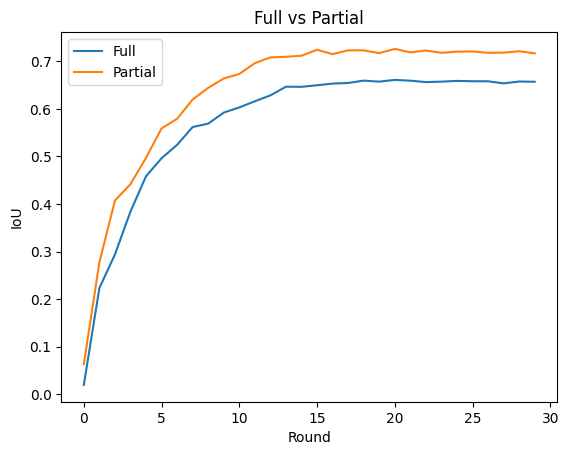

In [27]:
plot_results({'Full': iou_history_full, 'Partial': iou_history_partial}, 'Full vs Partial')

## Impact of client count

In [33]:
client_counts = [5, 10, 20]
iou_histories_clients = {}

for count in client_counts:
    # data = VocDataset('/content', VOC_COLORMAP)
    data = VocDataset('./', VOC_COLORMAP)
    train_set, val_set = torch.utils.data.random_split(data, [int(len(data) * 0.9), len(data) - int(len(data) * 0.9)])
    global_model = smp.Unet(encoder_name='resnet18', classes=21, activation='softmax').to(device)

    print(f"\n=== Client Count: {count} ===")
    iou_histories_clients[count] = federated_learning_with_analysis(
        global_model, train_set, val_set, num_clients=count, rounds=30, target_iou=0.9
    )


=== Client Count: 5 ===

Round 1/30
Validation Loss: 0.7496, Validation IoU: 0.2421

Round 2/30
Validation Loss: 0.6510, Validation IoU: 0.4195

Round 3/30
Validation Loss: 0.5825, Validation IoU: 0.4858

Round 4/30
Validation Loss: 0.4795, Validation IoU: 0.5473

Round 5/30
Validation Loss: 0.4337, Validation IoU: 0.5878

Round 6/30
Validation Loss: 0.3806, Validation IoU: 0.6379

Round 7/30
Validation Loss: 0.3378, Validation IoU: 0.6591

Round 8/30
Validation Loss: 0.3111, Validation IoU: 0.6662

Round 9/30
Validation Loss: 0.2798, Validation IoU: 0.6745

Round 10/30
Validation Loss: 0.2695, Validation IoU: 0.6770

Round 11/30
Validation Loss: 0.2601, Validation IoU: 0.6734

Round 12/30
Validation Loss: 0.2526, Validation IoU: 0.6730

Round 13/30
Validation Loss: 0.2491, Validation IoU: 0.6717

Round 14/30
Validation Loss: 0.2470, Validation IoU: 0.6699

Round 15/30
Validation Loss: 0.2448, Validation IoU: 0.6702

Round 16/30
Validation Loss: 0.2425, Validation IoU: 0.6645

Round 1

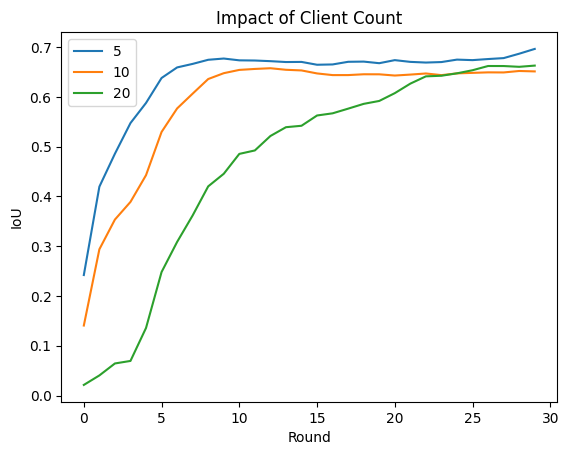

In [34]:
plot_results(iou_histories_clients, 'Impact of Client Count')

In [35]:
final_ious_clients = {count: history[-1] for count, history in iou_histories_clients.items()}
best_client_count = max(final_ious_clients, key=final_ious_clients.get)

print("\n=== Client Count Analysis ===")
print("Final IoUs for each client count:")
for count, iou in final_ious_clients.items():
    print(f"Clients: {count}, Final IoU = {iou:.4f}")

print(f"\nBest Client Count: {best_client_count}, IoU = {final_ious_clients[best_client_count]:.4f}")


=== Client Count Analysis ===
Final IoUs for each client count:
Clients: 5, Final IoU = 0.6963
Clients: 10, Final IoU = 0.6511
Clients: 20, Final IoU = 0.6628

Best Client Count: 5, IoU = 0.6963


## Hyperparameter tuning

In [51]:
import torch
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [8, 16, 32]

iou_histories_hyperparams = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        print("\n=== Hyperparameter tuning ===")
        print(f"Training with learning rate: {lr}, batch size: {batch_size}")
        
        global_model = smp.Unet(encoder_name='resnet18', classes=21, activation='softmax').to(device)
        
        iou_histories_hyperparams[(lr, batch_size)] = federated_learning_with_analysis(
            global_model, train_set, val_set, num_clients=10, rounds=30, target_iou=0.8, lr=lr, batch_size=batch_size
        )


=== Hyperparameter tuning ===
Training with learning rate: 0.0001, batch size: 8

Round 1/30
Validation Loss: 0.9407, Validation IoU: 0.0094

Round 2/30
Validation Loss: 0.8618, Validation IoU: 0.0147

Round 3/30
Validation Loss: 0.7838, Validation IoU: 0.2254

Round 4/30
Validation Loss: 0.7288, Validation IoU: 0.3228

Round 5/30
Validation Loss: 0.6881, Validation IoU: 0.3750

Round 6/30
Validation Loss: 0.6476, Validation IoU: 0.4319

Round 7/30
Validation Loss: 0.5954, Validation IoU: 0.4705

Round 8/30
Validation Loss: 0.5571, Validation IoU: 0.4904

Round 9/30
Validation Loss: 0.5062, Validation IoU: 0.5307

Round 10/30
Validation Loss: 0.4683, Validation IoU: 0.5403

Round 11/30
Validation Loss: 0.4361, Validation IoU: 0.5735

Round 12/30
Validation Loss: 0.3793, Validation IoU: 0.6450

Round 13/30
Validation Loss: 0.3394, Validation IoU: 0.6649

Round 14/30
Validation Loss: 0.3127, Validation IoU: 0.6703

Round 15/30
Validation Loss: 0.2922, Validation IoU: 0.6708

Round 16/30

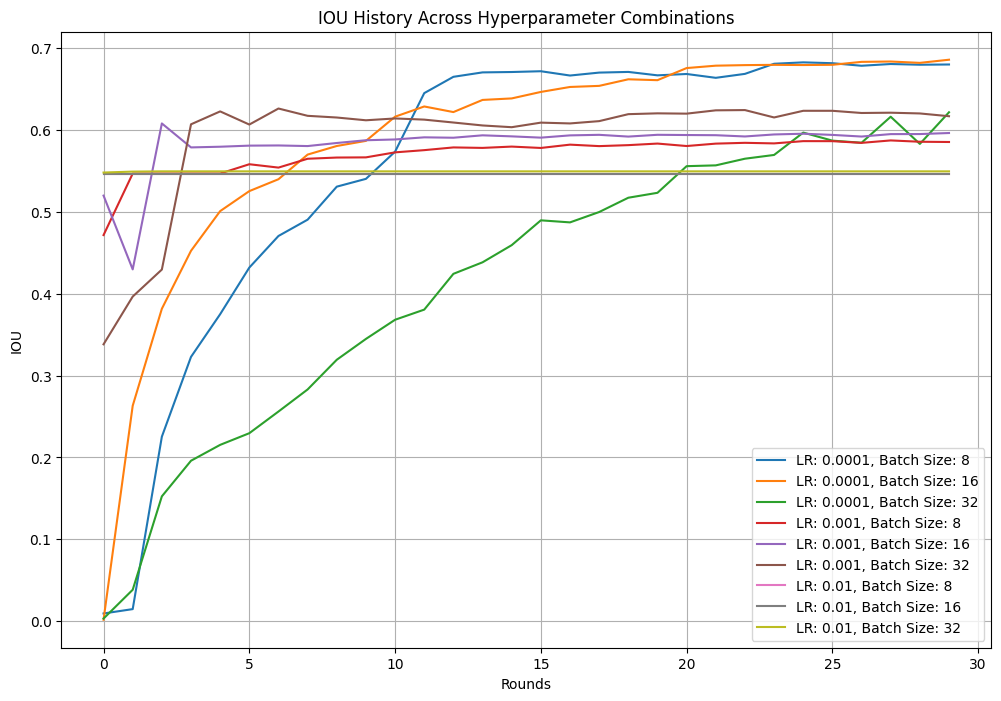

In [52]:
# Visualization
plt.figure(figsize=(12, 8))
for (lr, batch_size), iou_history in iou_histories_hyperparams.items():
    plt.plot(iou_history, label=f"LR: {lr}, Batch Size: {batch_size}")

plt.xlabel("Rounds")
plt.ylabel("IOU")
plt.title("IOU History Across Hyperparameter Combinations")
plt.legend()
plt.grid()
plt.show()